# Displaying Predictions made with Model_to_prediction.ipynb

In [71]:
#dependencies
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import shutil

In [72]:
#Helper class
class Reclangle:
    def __init__(self,x,y,w,h,conf):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.conf = conf
    def data(self):
        return [self.x,self.y],self.w,self.h,self.conf

## Define from which run we wish to display data from

In [73]:
predicition_run_folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/run_applied/run24'#'run_applied/run25' 

In [74]:
unserialized_data = []
folder = str()
for file in os.listdir(predicition_run_folder):
    if file == 'data_batch.pickle':
        with open(os.path.join(predicition_run_folder,file), 'rb') as pickle_file:
            try:
                while True:
                    article = pickle.load(pickle_file)
                    folder = article['folder']
                    print('!! Please check that image folder is : ' + str(article['folder'])+ ' !!')
            except EOFError:
                pass
    else:
        print('Loading... ' + file)
        with open(os.path.join(predicition_run_folder,file), 'rb') as pickle_file:
            try:
                while True:
                    article = pickle.load(pickle_file)
                    for element in article:
                        unserialized_data.append(element)
            except EOFError:
                pass
print('Running with ' + str(len(unserialized_data)) + ' images')

Loading... batch51.pickle
Loading... batch15.pickle
Loading... batch0.pickle
Loading... batch37.pickle
Loading... batch17.pickle
Loading... batch46.pickle
Loading... batch53.pickle
Loading... batch25.pickle
Loading... batch55.pickle
Loading... batch33.pickle
Loading... batch5.pickle
Loading... batch30.pickle
Loading... batch32.pickle
Loading... batch47.pickle
Loading... batch10.pickle
Loading... batch2.pickle
Loading... batch52.pickle
Loading... batch8.pickle
Loading... batch36.pickle
Loading... batch40.pickle
Loading... batch27.pickle
Loading... batch13.pickle
Loading... batch31.pickle
Loading... batch11.pickle
Loading... batch23.pickle
Loading... batch45.pickle
Loading... batch12.pickle
Loading... batch41.pickle
Loading... batch21.pickle
Loading... batch18.pickle
Loading... batch54.pickle
Loading... batch3.pickle
Loading... batch7.pickle
Loading... batch20.pickle
Loading... batch22.pickle
Loading... batch4.pickle
Loading... batch48.pickle
Loading... batch50.pickle
Loading... batch14.

## Plotting a cumulative distribution histogram

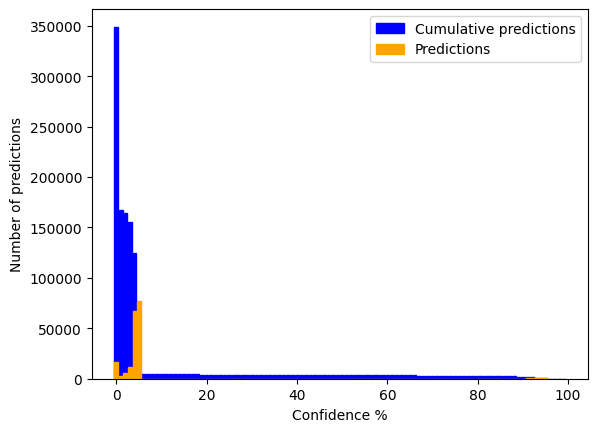

In [75]:
start = 0 #The start confidence as plotting from 0 often lead to unreadable results

x = range(100) #Confidence from 0 to 100
y = np.zeros((100)) #Empty array

######Plotting cumulatively#####
for i in range(len(unserialized_data)):
    for element in unserialized_data[i]['confidence']:
        for t in x:
            if t/100<element:
                y[t] +=1
    if len(unserialized_data[i]['confidence'])==1:
        y[0]+=1

x = x[start:]
y = y[start:]

plt.figure()
bar0 = plt.bar(x,y,label=range(start,100))
for bar in bar0:
    bar.set_color('blue')
################################ 

x = range(100) #Confidence from 0 to 100
y = np.zeros((100)) #Empty array

######Plotting distribution#####
for i in range(len(unserialized_data)):
    for element in unserialized_data[i]['confidence']:
        y[round(element*100)]+=1
x = x[start:]
y = y[start:]
bar1 = plt.bar(x,y,label=range(start,100))
for bar in bar1:
    bar.set_color('orange')
################################


plt.xlabel('Confidence %')
plt.ylabel('Number of predictions')
legend_handles = [plt.Rectangle((0, 0), 1, 1, color='blue'), 
                  plt.Rectangle((0, 0), 1, 1, color='orange')]
legend_labels = ['Cumulative predictions', 'Predictions']
plt.legend(legend_handles, legend_labels)
plt.show()


## Display best images
We first need to slightly change the data structure to find the max confidence and sort by this value

In [76]:
new_data = []
for element in unserialized_data:
    if len(element['confidence'])>0:
            max_value = max(element['confidence'])
            max_index = element['confidence'].index(max_value)
            new_data.append({'image':element['image'], 'image_shape': element['image_shape'], 'contour': element['contour'],'bbox' : element['bbox'], 'confidence' : element['confidence'], 'index_iw': max_index, 'max_confidence' : max_value})

In [77]:
#helper function to change size to the images to the same size used in Model_to_prediction.ipynb
def longest_max_size(image, max_size, interpolation=cv2.INTER_LINEAR):
    height, width = image.shape[:2]
    aspect_ratio = width / height

    if width > height:
        new_width = max_size
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = max_size
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=interpolation)
    return resized_image

def pad_if_needed(image, min_height, min_width, border_mode=cv2.BORDER_CONSTANT):
    height, width = image.shape[:2]

    if height < min_height or width < min_width:
        pad_top = max(0, min_height - height) // 2
        pad_bottom = max(0, min_height - height - pad_top)
        pad_left = max(0, min_width - width) // 2
        pad_right = max(0, min_width - width - pad_left)

        padded_image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, border_mode, value = (255, 255, 255))
    else:
        padded_image = image

    return padded_image

def display_images(sorted_dataset, start, end):
    if (end-start)>20:
        print('too many images requested')
        return
    for i in sorted_dataset.index[start:end]:
        plt.figure()
        element = sorted_dataset.loc[i]
        max_index = element['index_iw']
        img = cv2.imread(os.path.join(image_folder,element['image']))
        img = longest_max_size(img, max_size=element['image_shape'][1], interpolation=cv2.INTER_LINEAR)
        img = pad_if_needed(img, min_height=element['image_shape'][1], min_width=element['image_shape'][2], border_mode=cv2.BORDER_CONSTANT)
        for j in range(len(element['contour'])):
            cv2.drawContours(img, [element['contour'][j]],-1,(250),3)
            org = element['bbox'][j].data()[0]
            img = cv2.putText(img, str(round(element['confidence'][j]*100,2)) + '%', org, font, 
                       fontScale, color, thickness, cv2.LINE_AA)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return
def display_one_image(sorted_dataset,index,save_path=None):
    plt.figure()
    element = sorted_dataset.loc[index]
    max_index = element['index_iw']
    img = cv2.imread(os.path.join(image_folder,element['image']))
    img = longest_max_size(img, max_size=element['image_shape'][1], interpolation=cv2.INTER_LINEAR)
    img = pad_if_needed(img, min_height=element['image_shape'][1], min_width=element['image_shape'][2], border_mode=cv2.BORDER_CONSTANT)
    for j in range(len(element['contour'])):
        if (element['confidence'][j]>0.8):
            cv2.drawContours(img, [element['contour'][j]],-1,(250),1)
            org = element['bbox'][j].data()[0]
            img = cv2.putText(img, str(round(element['confidence'][j]*100,2)) + '%', org, font, 
                       fontScale, color, thickness, cv2.LINE_AA)
    plt.imshow(img)
    plt.axis('off')
    if save_path!=None:
        plt.savefig(os.path.join(save_path,element['image'])) #Save image if needed
    plt.show()
    return
def search_and_display(names,save_path=None):
    for name in names:
        for index in sorted_data.loc[sorted_data['image'].str.contains(name)==True].index.values:
            display_one_image(sorted_data,index,save_path) 

In [78]:
%matplotlib inline

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5 #Confidence size
color = (255, 0, 0) #Contour color
thickness = 1 #Contour thickness
image_folder =  folder #Value found in the metadata
data = pd.DataFrame.from_dict(new_data)

sorted_data = data.sort_values('max_confidence',ascending=False) #Sort by confidence level

display(sorted_data) #Display best values

,image,image_shape,contour,bbox,confidence,index_iw,max_confidence
9679,GANOT_22-550_3.jpg,"(3, 160, 160)","([[[97 39]], [[96 40]], [[94 40]], [[93 41]], ...",[<__main__.Reclangle object at 0x7fa67d068460>],[0.9787564357675432],0,0.978756
61930,GANOT_15-686_2.jpg,"(3, 160, 160)","([[[98 40]], [[97 41]], [[93 41]], [[92 42]], ...",[<__main__.Reclangle object at 0x7fa6456496c0>],[0.9779213076667306],0,0.977921
41759,GANOT_1-686_2.jpg,"(3, 160, 160)","([[[98 40]], [[97 41]], [[93 41]], [[92 42]], ...",[<__main__.Reclangle object at 0x7fa6470e9f00>],[0.9779213076667306],0,0.977921
151914,GANOT_8-556_2.jpg,"(3, 160, 160)","([[[119 95]], [[120 95]]], [[[114 94]], [[1...",[<__main__.Reclangle object at 0x7fa650c758a0>...,"[0.001064862182829529, 0.0011121139784033098, ...",3,0.977131
86135,GANOT_7-277_1.jpg,"(3, 160, 160)","([[[58 71]], [[57 72]], [[53 72]], [[52 73]], ...",[<__main__.Reclangle object at 0x7fa651286560>],[0.9770596323046945],0,0.977060
...,...,...,...,...,...,...,...
37746,MULLER_28-97_1.jpg,"(3, 160, 160)","([[[0 0]], [[ 0 159]], [[ 0 155]], [[ 1 154...",[<__main__.Reclangle object at 0x7fa67695f520>],[0.0017299891415032344],0,0.001730
42724,BOUTAN_1-438_2.jpg,"(3, 160, 160)","([[[0 0]], [[ 0 159]], [[ 0 155]], [[ 1 154...",[<__main__.Reclangle object at 0x7fa646b4f160>],[0.0017248870798321591],0,0.001725
84471,GANOT_5-571_5.jpg,"(3, 160, 160)","([[[ 3 155]], [[ 2 156]], [[ 2 157]], [[ 3...",[<__main__.Reclangle object at 0x7fa64ec89720>...,"[0.0015028076246380807, 0.0016933953563351679]",1,0.001693
86928,GANOT_7-837_1.jpg,"(3, 160, 160)","([[[0 0]], [[ 0 159]], [[ 0 155]], [[ 1 154...",[<__main__.Reclangle object at 0x7fa65062f730>],[0.001651446611175625],0,0.001651


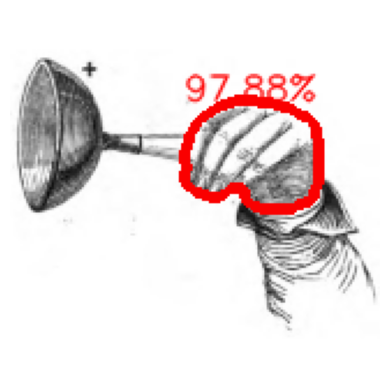

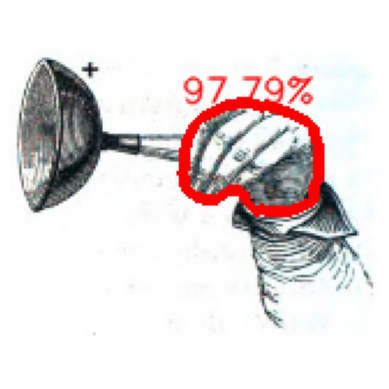

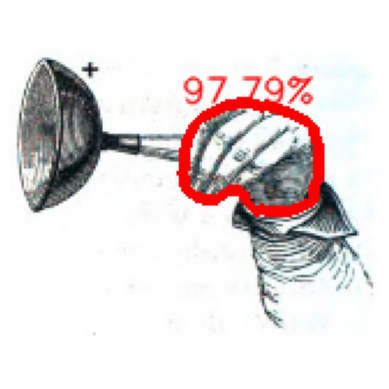

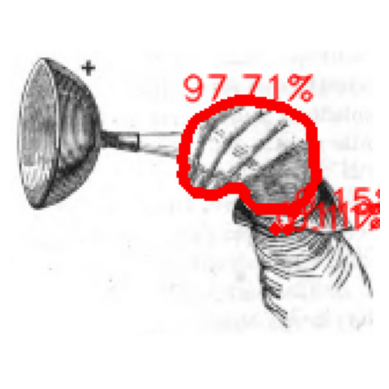

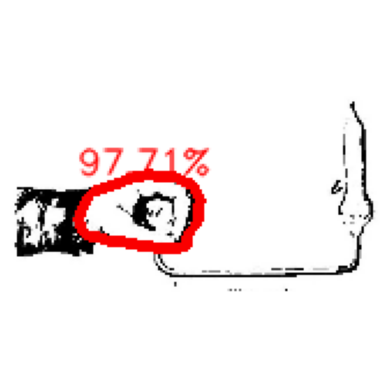

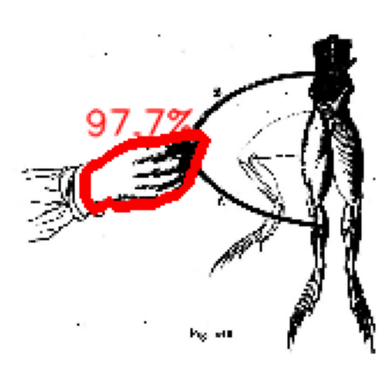

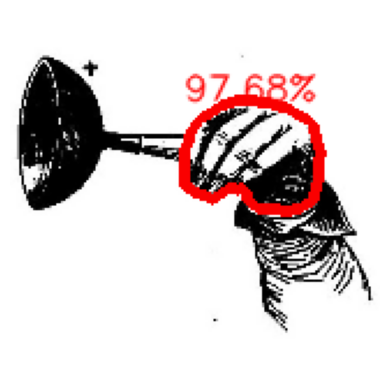

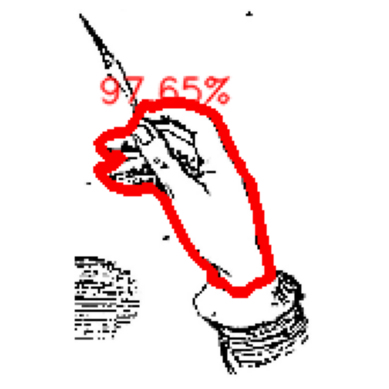

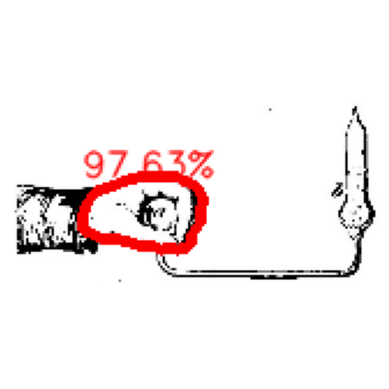

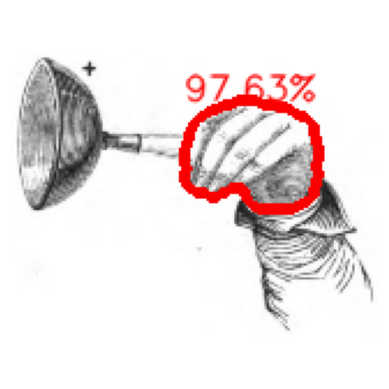

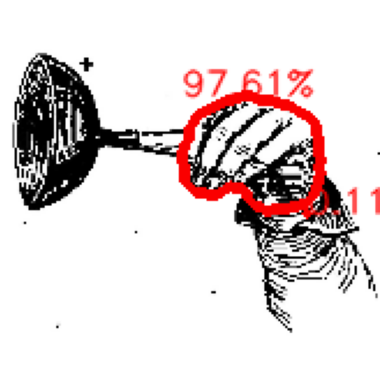

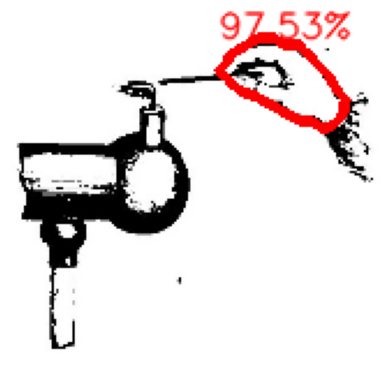

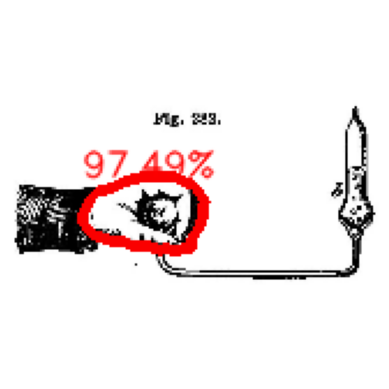

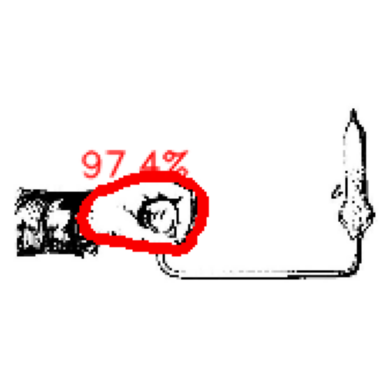

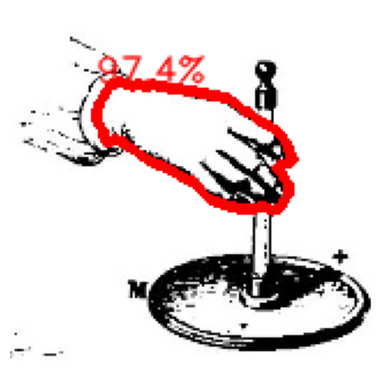

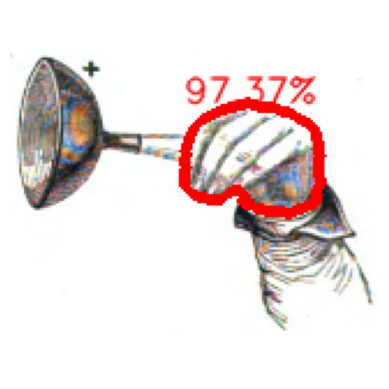

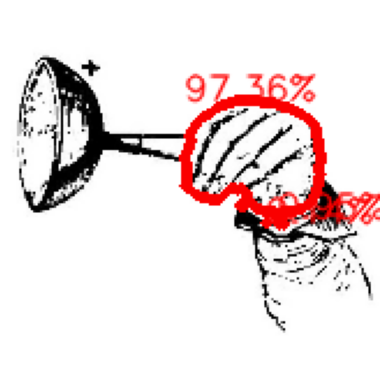

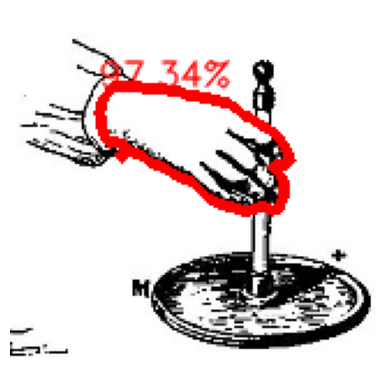

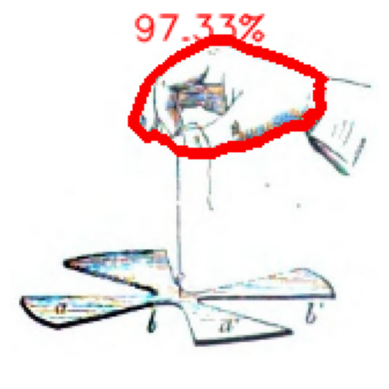

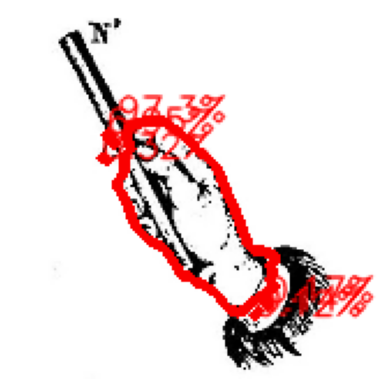

In [79]:
display_images(sorted_data,0,20) #Ploting the first 20 images

### Search in prediction, images from specific authors or books

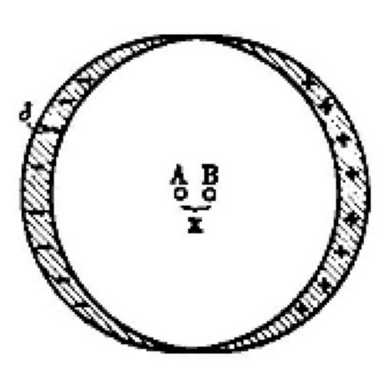

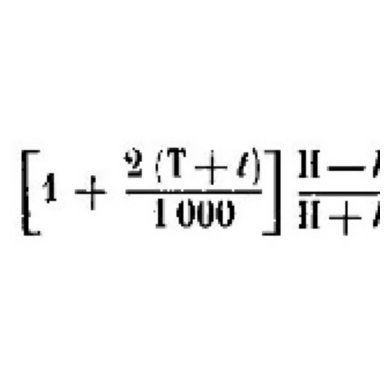

In [80]:
arr = ['MULLER_4-295','DRION_1-128']
search_and_display(arr)

## Copy detected images to folder 
This is a useful in order to have a folder of detected images for PCA

In [ ]:
THRESHOLD = 0.9 #The confidence threshold we want to use
write_path = 'detected_image'
for i in sorted_data.index[0:len(sorted_data)]:
    if sorted_data.iloc[i]['max_confidence']>THRESHOLD:
        shutil.copy(os.path.join(folder,sorted_data.iloc[i]['image']),os.path.join(write_path,sorted_data.iloc[i]['image']))
        print(sorted_data.iloc[i]['image'])

## Plotting a cumulative distribution histogram for each books

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 130.0
percentage : 0.6770833333333334


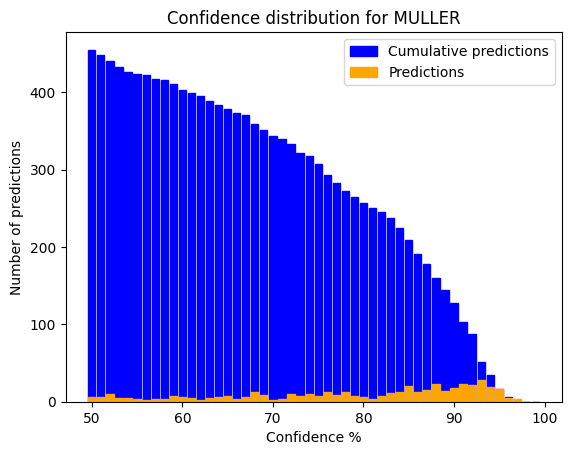

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 427.0
percentage : 0.2773627801234167


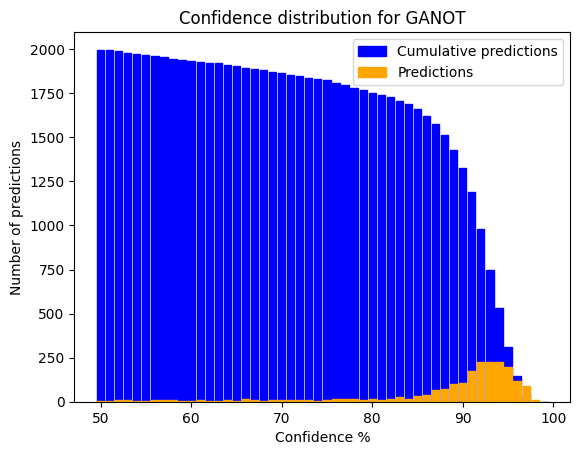

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 38.0
percentage : 0.36893203883495146


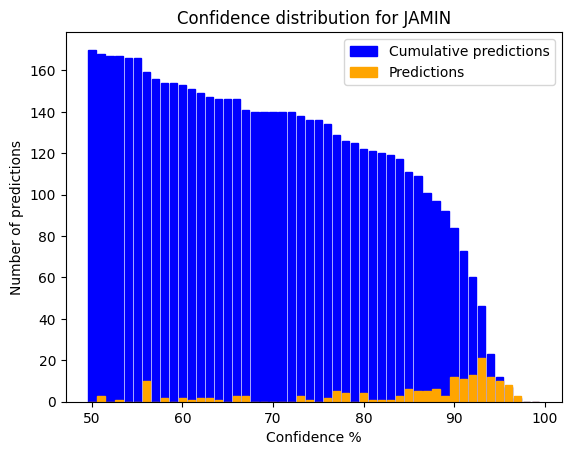

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 1.0
percentage : 0.4


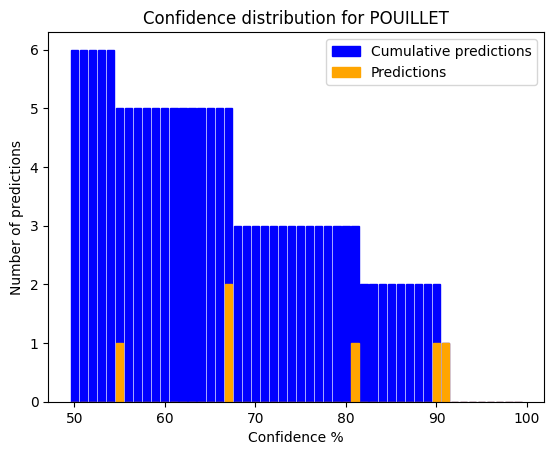

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 4.0
percentage : 0.5714285714285714


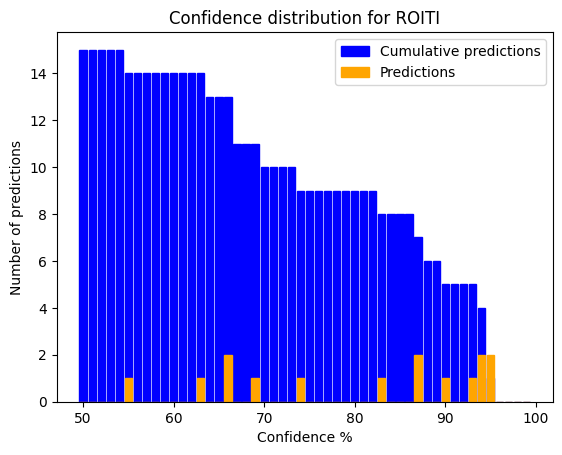

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 2.0
percentage : 0.5


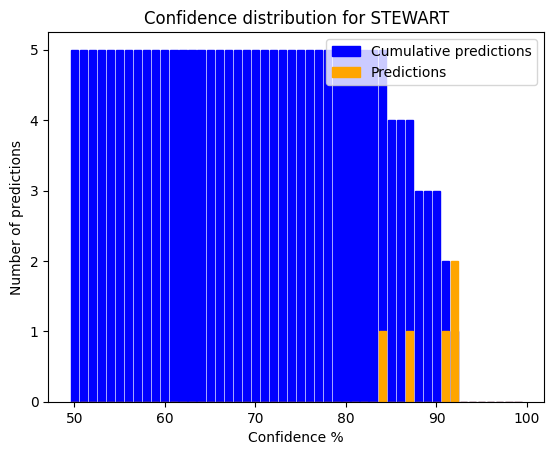

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 1.0
percentage : 0.4


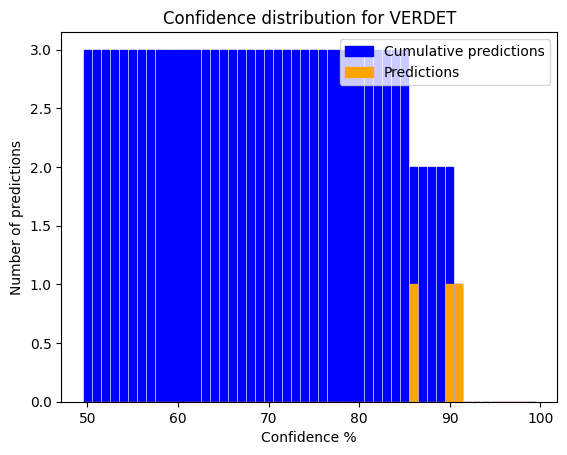

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 32.0
percentage : 0.4050632911392405


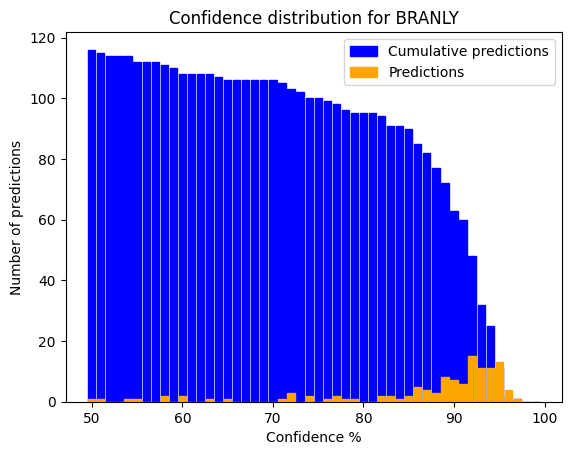

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 23.0
percentage : 0.4842105263157895


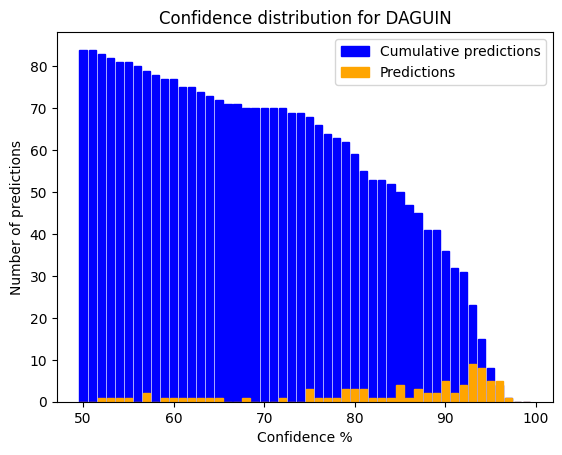

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 5.0
percentage : 0.2222222222222222


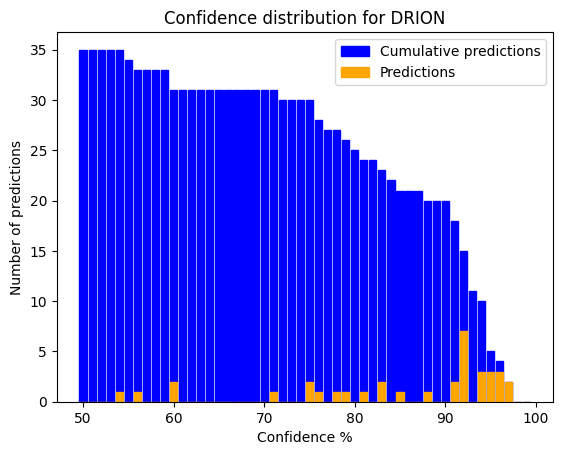

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 14.0
percentage : 0.5384615384615384


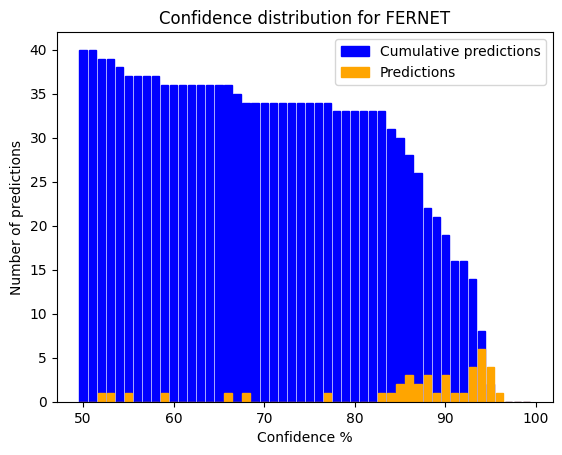

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 151.0
percentage : 0.6411889596602972


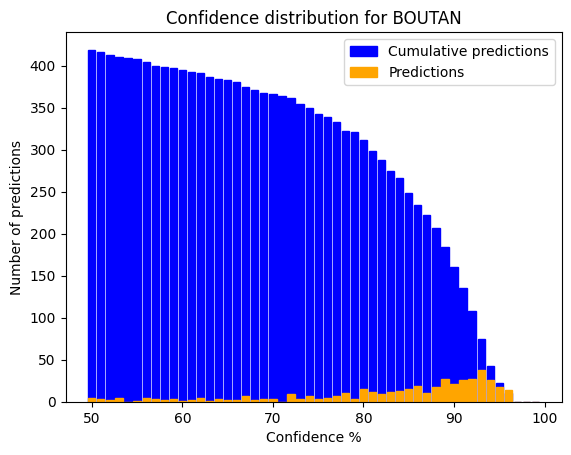

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 0.0
percentage : nan


/tmp/ipykernel_1384138/4135084560.py:14: RuntimeWarning: invalid value encountered in scalar divide
  print('percentage : ' + str(2*(y[80]-y[90])/(y[80]+y[90])))


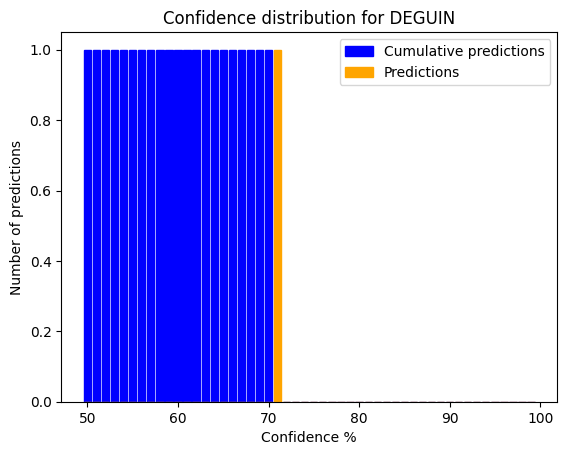

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 3.0
percentage : 0.35294117647058826


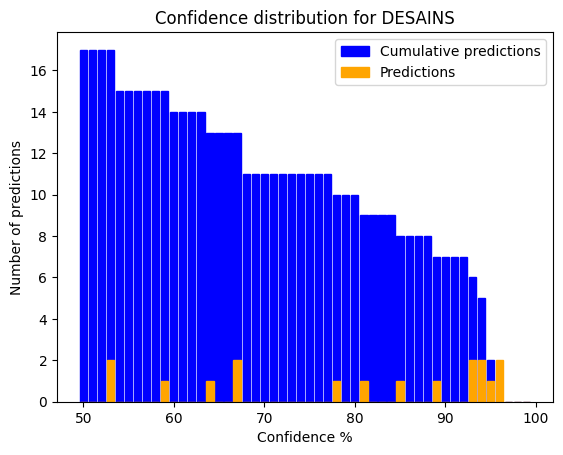

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 4.0
percentage : 0.6666666666666666


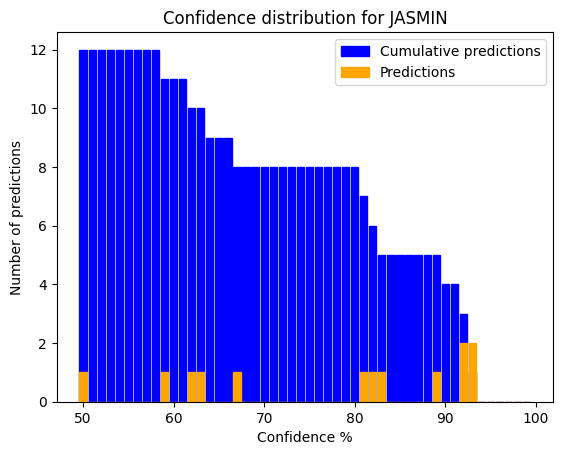

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 21.0
percentage : 0.4827586206896552


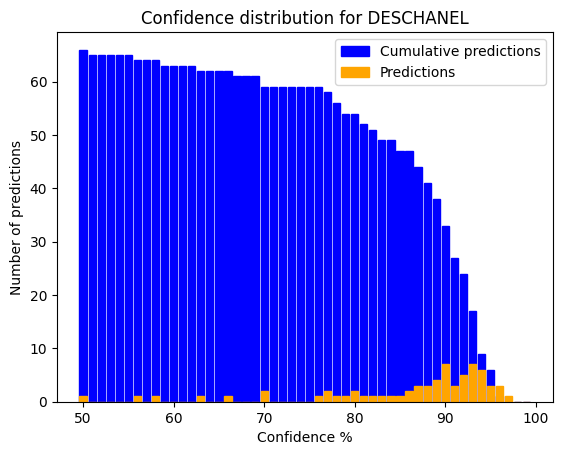

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 21.0
percentage : 0.5454545454545454


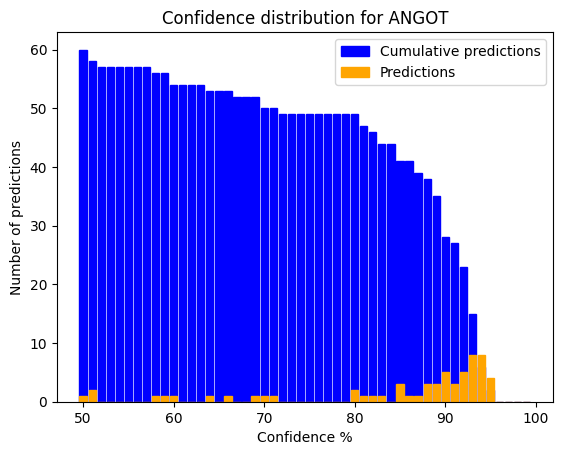

Proportion of prediction lost going from confidence 0.8 to 0.9:
total image : 1.0
percentage : 0.4


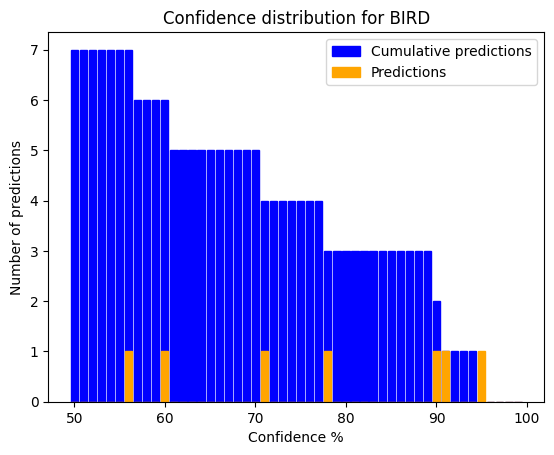

In [83]:
AUTHORS = ['MULLER', 'GANOT', 'JAMIN', 'POUILLET', 'ROITI', 'STEWART', 'VERDET', 'BRANLY', 'DAGUIN', 'DRION', 'FERNET', 'BOUTAN', 'DEGUIN', 'DESAINS', 'JASMIN', 'DESCHANEL', 'ANGOT', 'BIRD']
start = 50 #The start confidence as plotting from 0 often lead to unreadable results
for FOR_BOOK in AUTHORS:
    x = range(100)
    y = np.zeros((100))
    for i in range(len(unserialized_data)):
        if unserialized_data[i]['image'].split('_')[0]==FOR_BOOK:
            for element in unserialized_data[i]['confidence']:
                for t in x:
                    if t/100<element:
                        y[t] +=1
    print('Proportion of prediction lost going from confidence 0.8 to 0.9:')
    print('total image : '+ str(y[80]-y[90]))
    print('percentage : ' + str(2*(y[80]-y[90])/(y[80]+y[90])))
    
    x = x[start:]
    y = y[start:]
    plt.figure()
    bar0 = plt.bar(x,y,label=range(start,100))
    for bar in bar0:
        bar.set_color('blue')
        
    x = range(100)
    y = np.zeros((100))
    for i in range(len(unserialized_data)):
        if unserialized_data[i]['image'].split('_')[0]==FOR_BOOK:
            for element in unserialized_data[i]['confidence']:
                y[round(element*100)]+=1
                
    x = x[start:]
    y = y[start:]
    bar1 = plt.bar(x,y,label=range(start,100))
    for bar in bar1:
        bar.set_color('orange')
    plt.xlabel('Confidence %')
    plt.ylabel('Number of predictions')
    plt.title('Confidence distribution for ' + str(FOR_BOOK))
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color='blue'), 
                      plt.Rectangle((0, 0), 1, 1, color='orange')]
    legend_labels = ['Cumulative predictions', 'Predictions']
    plt.legend(legend_handles, legend_labels)
    plt.show()